In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools, viz_tools
import xarray as xr
import datetime
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
ferry_data = 'https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV1'
nowcast_data = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02'
bathy, X, Y = tidetools.get_bathy_data(grid)
ferry = nc.Dataset(ferry_data)
nowcast = xr.open_dataset(nowcast_data)

In [6]:
nc.num2date(ferry.variables['s.time'][680000], ferry.variables['s.time'].units)

datetime.datetime(2014, 9, 13, 5, 20)

In [7]:
nowcast_salinity = nowcast.salinity

In [8]:
nc.num2date(ferry.variables['s.time'][-1], ferry.variables['s.time'].units)

datetime.datetime(2017, 10, 27, 15, 12)

In [12]:
list_of_model_sals = np.array([])
list_of_ferry_sals = np.array([])
list_of_lons = np.array([])
unit = ferry.variables['s.time'].units
for n in range(680000,1450392):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.salinity'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        date = nc.num2date(ferry.variables['s.time'][n], unit)
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            delta = (date - before).seconds / 3600
            s_val = (delta * ((nowcast_salinity
                   .sel(time = before, depth = 1.5, method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast_salinity
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = 1.5, method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            delta = (date - before).seconds / 3600
            s_val = (delta * ((nowcast_salinity
                   .sel(time = before, depth = 1.5, method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values) + 
                   (1- delta)*((nowcast_salinity
                   .sel(time = before + datetime.timedelta(hours=1), 
                        depth = 1.5, method = 'nearest')
                   .isel(gridY = Yind, gridX = Xind)).values))
        list_of_ferry_sals = np.append(list_of_ferry_sals, ferry.variables['s.salinity'][n])
        list_of_model_sals = np.append(list_of_model_sals, s_val)
        list_of_lons = np.append(list_of_lons, ferry.variables['s.longitude'][n])

In [4]:
import pickle

In [16]:
output = open('ferry_sal.pkl', 'wb')
pickle.dump(list_of_ferry_sals, output)
output.close()
output = open('model_sal.pkl', 'wb')
pickle.dump(list_of_model_sals, output)
output.close()
output = open('lons.pkl', 'wb')
pickle.dump(list_of_lons, output)
output.close()

In [18]:
list_of_lons.shape

(433126,)

In [19]:
list_of_ferry_sals.shape

(433126,)

In [8]:
list_of_model_sals = pickle.load(open('../model_sal.pkl', 'rb'))
list_of_ferry_sals = pickle.load(open('../ferry_sal.pkl', 'rb'))
list_of_lons = pickle.load(open('../lons.pkl', 'rb'))

In [9]:
print(list_of_lons.min())
print(list_of_lons.max())

-123.95535
-123.0844


In [10]:
bounds = np.linspace(list_of_lons.min(), list_of_lons.max(), 11)

In [26]:
from matplotlib.colors import LogNorm

In [39]:
def make_plot(n):
    fig, ax = plt.subplots(figsize = (10,10))
    c, xedge, yedge, im = ax.hist2d(list_of_ferry_sals[(bounds[n]<=list_of_lons) 
                                                       &  (list_of_lons< bounds[n+1])], 
                                    list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                       &  (list_of_lons< bounds[n+1])], 
                                    bins = 100, norm=LogNorm())
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('Ferry Data')
    ax.set_ylabel('Nowcast-green')
    ax.plot(np.arange(0,35), 'r-')
    ax.set_title(str(bounds[n]) + ' < lon < ' + str(bounds[n+1]))
    print('bias =  ' + str(-np.mean(list_of_ferry_sals[(bounds[n]<=list_of_lons) 
                                                       & (list_of_lons< bounds[n+1])]) + 
                           np.mean(list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                      & (list_of_lons< bounds[n+1])])))
    print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                             &  (list_of_lons< bounds[n+1])] - 
                                          list_of_ferry_sals[(bounds[n]<=list_of_lons) 
                                                             & (list_of_lons< bounds[n+1])])**2) 
                                  / len(list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                           &  (list_of_lons< bounds[n+1])]))))
    xbar = np.mean(list_of_ferry_sals[(bounds[n]<=list_of_lons) &  (list_of_lons< bounds[n+1])])
    print('Willmott = ' + str(1-(np.sum((list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                            & (list_of_lons< bounds[n+1])] - 
                                         list_of_ferry_sals[(bounds[n]<=list_of_lons) 
                                                            &  (list_of_lons< bounds[n+1])])**2)  / 
                                 np.sum((np.abs(list_of_model_sals[(bounds[n]<=list_of_lons) 
                                                                   &  (list_of_lons< bounds[n+1])] 
                                                - xbar) 
                                         + np.abs(list_of_ferry_sals[(bounds[n]<=list_of_lons) 
                                                                     &  (list_of_lons< bounds[n+1])] 
                                                  - xbar))**2))))

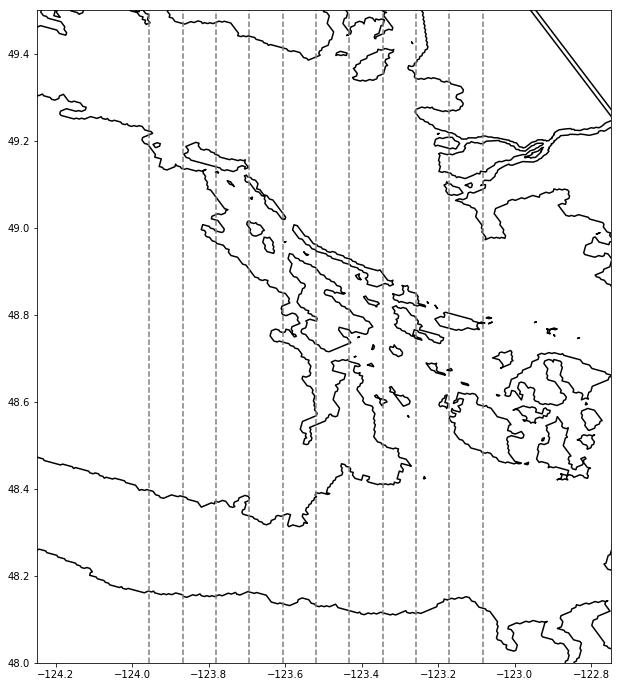

In [73]:
fig, ax = plt.subplots(figsize = (12,12))
viz_tools.plot_coastline(ax, grid, coords = 'map')
viz_tools.set_aspect(ax, coords = 'map')
ax.set_xlim(-124.25, -122.75)
ax.set_ylim(48, 49.5)
for p in range(11):
    ax.plot((bounds[p], bounds[p]), (48, 49.5), '--', color = 'grey')

bias =  -0.235046532223
RMSE = 3.27635078957
Willmott = 0.71035198825


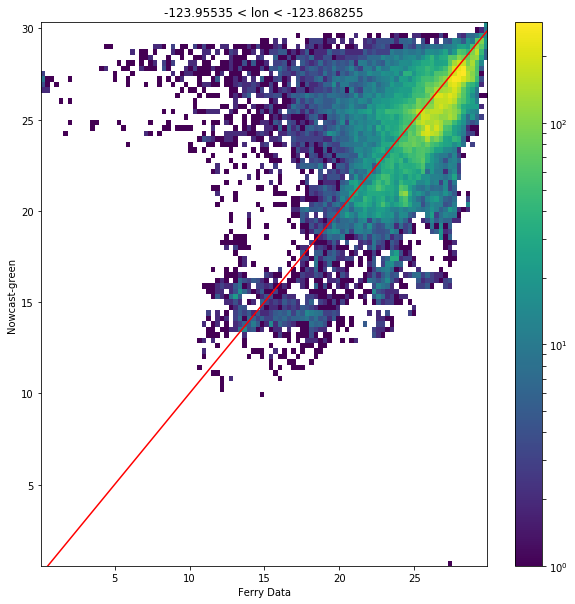

In [42]:
make_plot(0)

bias =  -0.643749411335
RMSE = 2.46313518013
Willmott = 0.814818517618


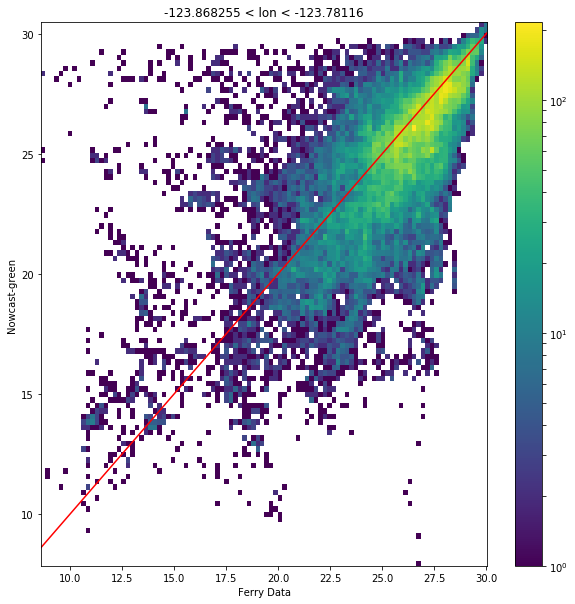

In [43]:
make_plot(1)

bias =  -0.613675946814
RMSE = 2.44344086331
Willmott = 0.820919795683


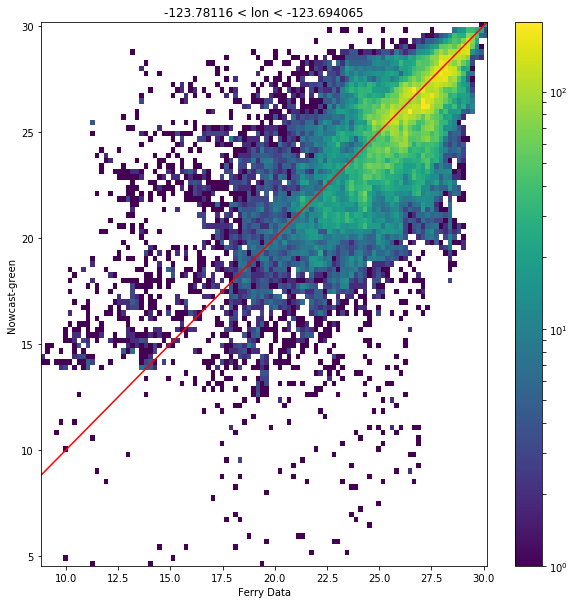

In [44]:
make_plot(2)

bias =  0.582249576516
RMSE = 3.60664024864
Willmott = 0.771024481231


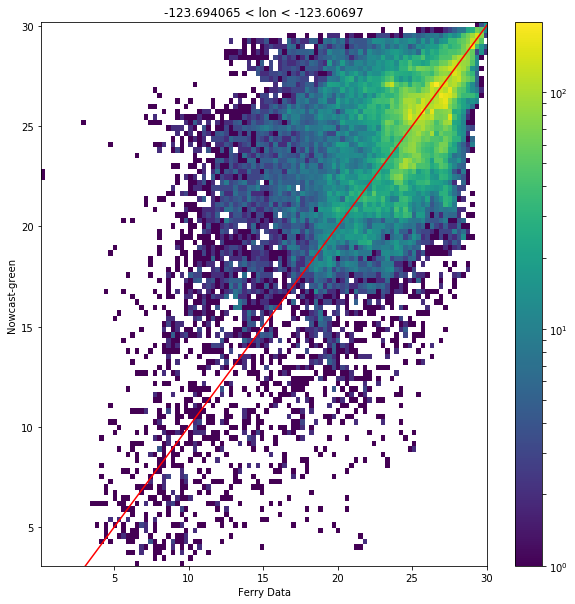

In [45]:
make_plot(3)

bias =  2.15830448104
RMSE = 5.00482982342
Willmott = 0.731819307486


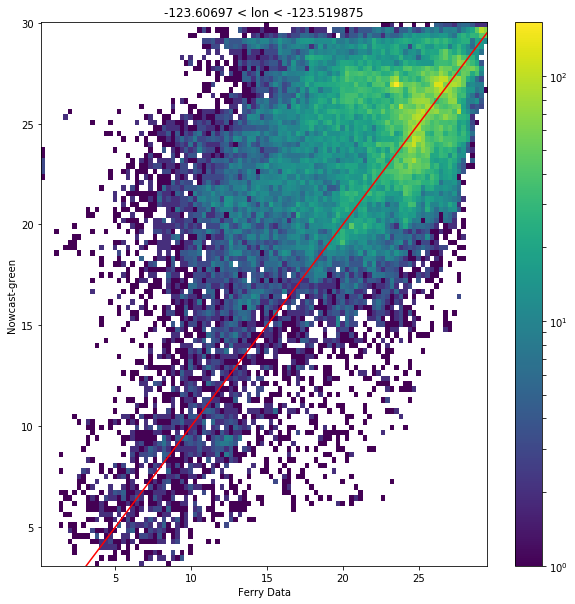

In [46]:
make_plot(4)

bias =  3.97642860673
RMSE = 6.51605845981
Willmott = 0.680860170383


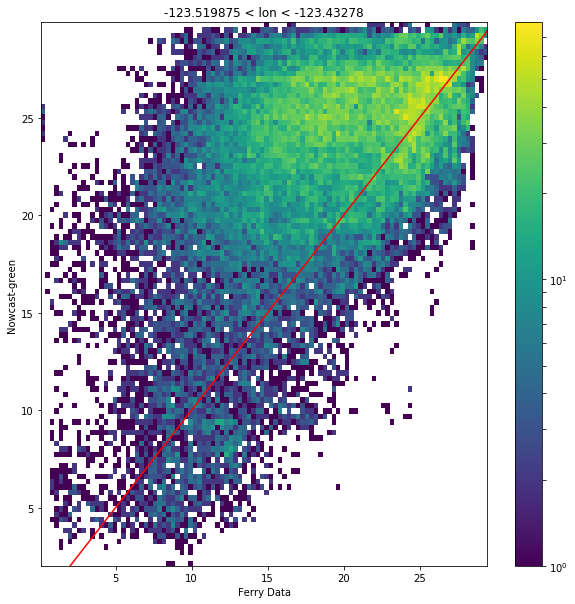

In [47]:
make_plot(5)

bias =  5.2685055872
RMSE = 7.49990352886
Willmott = 0.682583879015


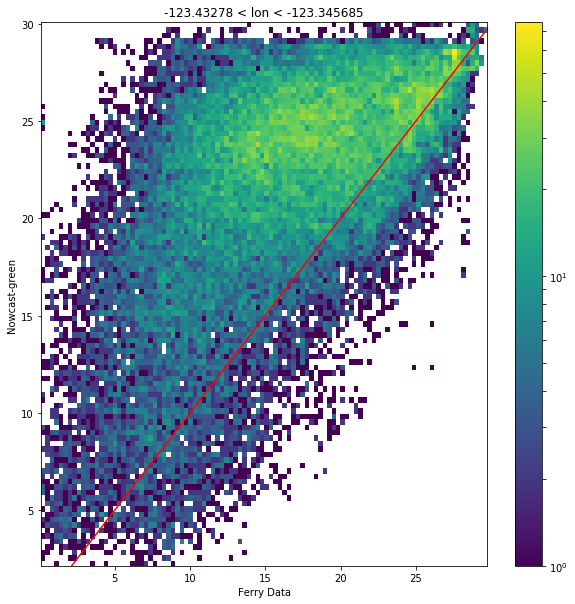

In [48]:
make_plot(6)

bias =  3.2816727365
RMSE = 5.77536007481
Willmott = 0.807977489696


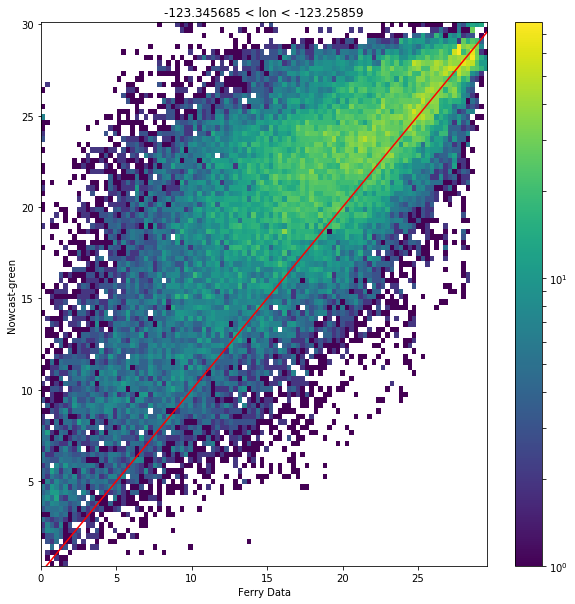

In [49]:
make_plot(7)

bias =  1.56106522839
RMSE = 4.95826212126
Willmott = 0.816730866015


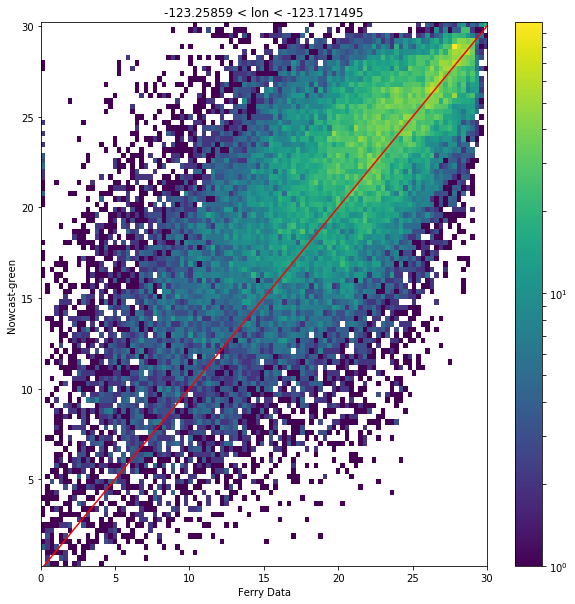

In [50]:
make_plot(8)

bias =  -0.491588995892
RMSE = 4.02634261139
Willmott = 0.757879771828


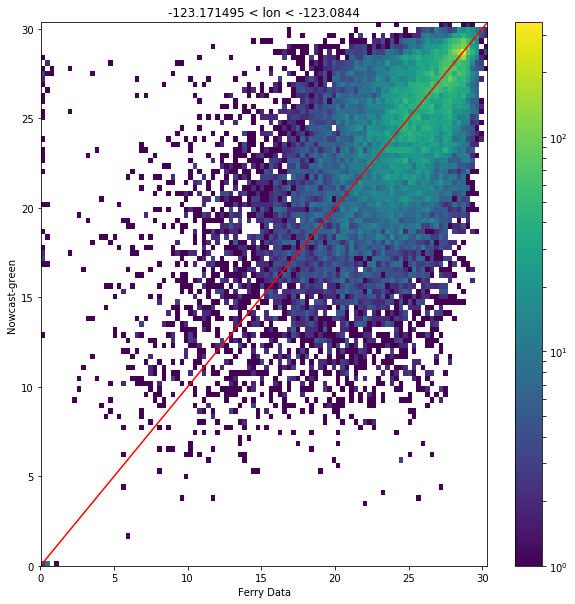

In [51]:
make_plot(9)

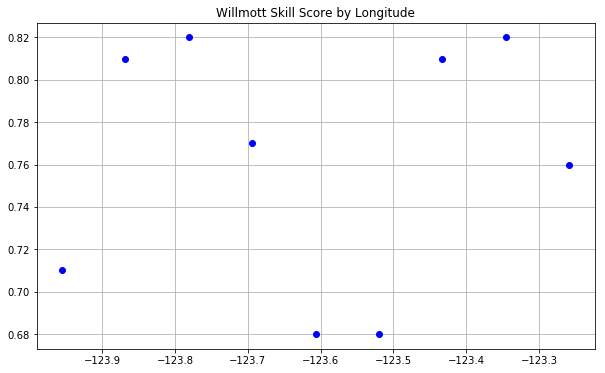

In [16]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(bounds[:-2], [0.71, 0.81, 0.82, 0.77, 0.68, 0.68, 0.81, 0.82, 0.76], 'bo')
ax.grid('on')
ax.set_title('Willmott Skill Score by Longitude')